# 恶意软件检测

**任务描述**

通过软件的API调用序列的分析，识别出是恶意软件还是正常软件

**数据集**
1. 包含42797个恶意软件（malware）API调用序列
2. 包含1079个正常软件（goodware）API调用序列
3. 每个API调用序列由前100个非重复序列组成

**字段解释**

1. hash：实例的MD5值
2. t_0-t_99：时间序列的API编号
3. malware：是否为恶意软件，0为正常，1为恶意

**模型技术**
1. LogisticRegression Model
2. TF-IDF Model
3. word2vec Model
4. Graph Embedding
5. LSTM

**项目效果**

1. 准确率：
2. 精确度：
3. 召回率：

# 数据探索

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
data = pd.read_csv('./dynamic_api_call_sequence_per_malware_100_0_306.csv')
data.head(3).append(data.tail(3))

,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,malware
0,071e8c3f8922e186e57548cd4c703a5d,112,274,158,215,274,158,215,298,76,...,71,297,135,171,215,35,208,56,71,1
1,33f8e6d08a6aae939f25a8e0d63dd523,82,208,187,208,172,117,172,117,172,...,81,240,117,71,297,135,171,215,35,1
2,b68abd064e975e1c6d5f25e748663076,16,110,240,117,240,117,240,117,240,...,65,112,123,65,112,123,65,113,112,1
43873,35a18ee05f75f04912018d9f462cb990,82,240,117,240,117,240,117,240,117,...,260,141,260,141,260,141,260,141,260,1
43874,654139d715abcf7ecdddbef5a84f224b,82,240,117,240,117,240,117,240,117,...,141,260,141,260,141,260,141,260,141,1
43875,078c9d4e7be4819a06974c6f292a4857,112,274,158,215,274,158,215,298,76,...,71,297,135,171,215,35,208,56,71,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43876 entries, 0 to 43875
Columns: 102 entries, hash to malware
dtypes: int64(101), object(1)
memory usage: 34.1+ MB


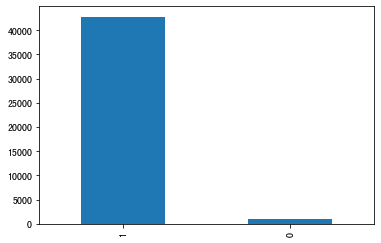

In [4]:
# 标签分布
data['malware'].value_counts().plot(kind='bar')
plt.show()

In [5]:
# 缺失值情况
data.isnull().sum()[data.isnull().sum() != 0]

Series([], dtype: int64)

In [6]:
# 重复值
data[data.duplicated()]

,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,malware
14665,075323e77815ee8bcc7854ce23955a15,16,172,274,158,215,274,158,215,274,...,215,274,158,215,274,158,215,274,158,0
16891,bdaaac3fa3f6796825a51ef1c0e5b3fd,82,240,117,240,117,240,117,240,117,...,260,65,260,141,65,112,113,65,289,0
21713,03384ab6368b68ed16ecb9e6352539af,16,172,274,158,215,274,158,215,274,...,215,274,158,215,274,158,215,274,158,0
33626,f78ea80cec007b2c32fb10f9c6c82f39,16,172,274,158,215,274,158,215,274,...,215,274,158,215,274,158,215,274,158,0


In [7]:
# API总数量
t_col = [x for x in data.columns.tolist() if x not in ['hash', 'malware']]
api_num = len(set(data[t_col].values.reshape(1,-1).tolist()[0]))
print('API总数量；', api_num)

API总数量； 264


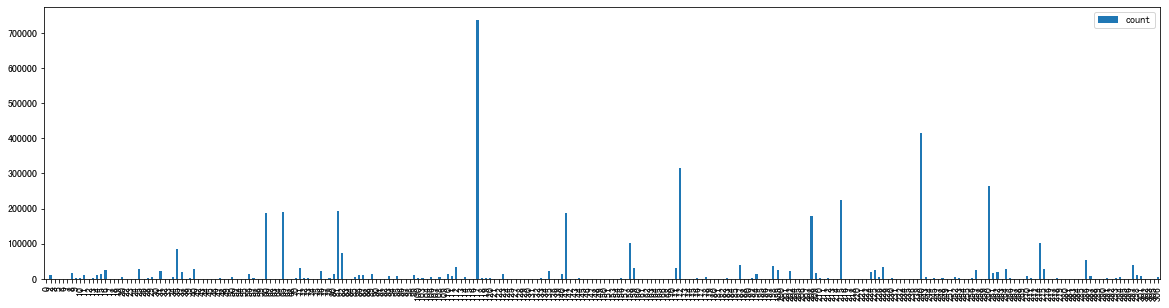

In [8]:
# API调用次数分布数据可视化
api_count = defaultdict(int)

for t in data[t_col].values:
    for api in t:
        api_count[api] += 1

df_api = pd.DataFrame(api_count.values(), index=api_count.keys(), columns=['count'])
df_api.sort_index().plot(kind='bar', figsize=(20, 5))
plt.show()        

# 数据预处理

In [9]:
# 删除重复值
data.drop_duplicates(inplace=True,)

In [10]:
# API编号重新编码
api_to_idx = {x: idx for idx, x in enumerate(list(api_count.keys()))}
idx_to_api = {idx: x for x, idx in list(api_to_idx.items())}

# 修改datafram
for col in t_col:
    data[col] = data[col].apply(lambda x: api_to_idx[x])
data.head()

,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,malware
0,071e8c3f8922e186e57548cd4c703a5d,0,1,2,3,1,2,3,4,5,...,16,17,18,19,3,9,6,20,16,1
1,33f8e6d08a6aae939f25a8e0d63dd523,21,6,22,6,7,8,7,8,7,...,11,12,8,16,17,18,19,3,9,1
2,b68abd064e975e1c6d5f25e748663076,23,34,12,8,12,8,12,8,12,...,29,0,40,29,0,40,29,39,0,1
3,72049be7bd30ea61297ea624ae198067,21,6,22,6,7,8,7,8,7,...,6,47,6,47,22,6,47,41,47,1
4,c9b3700a77facf29172f32df6bc77f48,21,12,8,12,8,12,8,12,8,...,59,27,58,59,27,36,27,36,27,1


In [11]:
# 特征标签分离
features = data[t_col]
labels = data['malware']

# 数据集拆分

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=529)
print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

x_train (29394, 100)
y_train (29394,)
x_test (14478, 100)
y_test (14478,)


# 训练模型最低准确率
由于样本极端不平衡，如果全部预测为1（恶意）的准确率如下

In [14]:
print('最低标准准确率：{:.2f}%'.format((data['malware'].value_counts() / len(data)).max()*100))

最低标准准确率：97.55%


# Baseline 模型
思路：把api重新编号后直接用逻辑回归进行拟合。

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc

In [16]:
# 数据规范化
ss = StandardScaler()
lr_features = ss.fit_transform(x_train)

# 模型训练
lr = LogisticRegression()
lr.fit(lr_features, y_train)

# 模型预测
lr_predict_features = ss.transform(x_test)
lr_predict = lr.predict(lr_predict_features)

# auc值计算
lr_y_score = lr.predict_proba(lr_predict_features)[:,1]
lr_fpr, lr_tpr, thresholds = roc_curve(y_test, lr_y_score)
lr_roc_auc = auc(lr_fpr, lr_tpr)

# 评估分数
print('--- LogisticRegression Baseline ---')
print('准确率：{:.4f}'.format(accuracy_score(lr_predict, y_test)))
print('精确度：{:.4f}'.format(precision_score(lr_predict, y_test)))
print('召回率：{:.4f}'.format(recall_score(lr_predict, y_test)))
print('AUC值：{:.4f}'.format(lr_roc_auc))

--- LogisticRegression Baseline ---
准确率：0.9817
精确度：0.9983
召回率：0.9832
AUC值：0.8181


# TF-IDF 模型
思路：把每个api看作是一个单词，一次调用的时序数据就是一个由多个单词组成的句子，从而提取单词TF-IDF值作为特征进行拟合。

## TF-IDF 特征构造

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
# 转换成文本句子格式
train_content_list = [' '.join(map(str, x)) for x in x_train.values.tolist()]
test_content_list = [' '.join(map(str, x)) for x in x_test.values.tolist()]

# 构造tf-idf特征
vector = TfidfVectorizer(token_pattern='\w+')
train_tfidf_features = vector.fit_transform(train_content_list)
test_tfidf_features = vector.transform(test_content_list)

## TF-IDF 模型训练

In [19]:
# LR模型训练
lr = LogisticRegression()
lr.fit(train_tfidf_features, y_train)

# 模型预测
tfidf_predict = lr.predict(test_tfidf_features)
tfidf_predict_proba = lr.predict_proba(test_tfidf_features)

# auc值计算
tfidf_y_score = tfidf_predict_proba[:,1]
tfidf_fpr, tfidf_tpr, thresholds = roc_curve(y_test, tfidf_y_score)
tfidf_roc_auc = auc(tfidf_fpr, tfidf_tpr)

# 评估分数
print('--- TF-IDF Model ---')
print('准确率：{:.4f}'.format(accuracy_score(tfidf_predict, y_test)))
print('精确度：{:.4f}'.format(precision_score(tfidf_predict, y_test)))
print('召回率：{:.4f}'.format(recall_score(tfidf_predict, y_test)))
print('AUC值：{:.4f}'.format(tfidf_roc_auc))

--- TF-IDF Model ---
准确率：0.9778
精确度：0.9996
召回率：0.9781
AUC值：0.9183


# word2vec 模型
思路：采用word2vec训练出每个api的向量，每一个样本的特征就是所有api向量之和

## word2vec 特征构造

In [20]:
from gensim.models import word2vec
from functools import reduce

In [21]:
# 转换成文本句子格式
w2v_sentence_list = [[str(y) for y in x] for x in features.values]

# 训练每个词的word2vec模型
emb_size = 256
model = word2vec.Word2Vec(sentences=w2v_sentence_list, size=emb_size, window=5, min_count=0)

In [22]:
# 构造每个样本的特征向量
def get_vec(x, model, size):
    result = np.zeros(shape=(x.values.shape[0], size))
    for idx, sample in enumerate(x.values.tolist()):
        temp_array = np.zeros(shape=(size))
        result[idx] = reduce(lambda x,y: x+model[str(y)], sample)
    return result

In [23]:
# 生成样本特征
w2v_train_features = get_vec(x_train, model, emb_size)
w2v_test_features = get_vec(x_test, model, emb_size)

# 查看样本维度
print('w2v_train_features', w2v_train_features.shape)
print('w2v_test_features', w2v_test_features.shape)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


w2v_train_features (29394, 256)
w2v_test_features (14478, 256)


## word2vec + LR 模型训练

In [24]:
# 数据规范化
ss = StandardScaler()
w2v_train_features = ss.fit_transform(w2v_train_features)
w2v_test_features = ss.transform(w2v_test_features)

# 模型训练
w2v_lr = LogisticRegression(max_iter=1000)
w2v_lr.fit(w2v_train_features, y_train)

# 模型预测
w2v_predict = w2v_lr.predict(w2v_test_features)
w2v_predict_proba = w2v_lr.predict_proba(w2v_test_features)

# auc值计算
w2v_y_score = w2v_predict_proba[:,1]
w2v_fpr, w2v_tpr, thresholds = roc_curve(y_test, w2v_y_score)
w2v_roc_auc = auc(w2v_fpr, w2v_tpr)

# 评估分数
print('--- wore2vec + LR ---')
print('准确率：{:.4f}'.format(accuracy_score(w2v_predict, y_test)))
print('精确度：{:.4f}'.format(precision_score(w2v_predict, y_test)))
print('召回率：{:.4f}'.format(recall_score(w2v_predict, y_test)))
print('AUC值：{:.4f}'.format(w2v_roc_auc))

--- wore2vec + LR ---
准确率：0.9803
精确度：0.9957
召回率：0.9843
AUC值：0.8911


# GCN 模型
思路：根据api调用顺序构建出图，采用GCN方式构建特征再进行拟合

## 构建图

In [25]:
import networkx as nx

In [26]:
# 构建图
DG = nx.DiGraph()

# 构建带权重边
edges_dict = defaultdict(int)
for api_seq in  data[t_col].values.tolist():
    for i in range(1, len(api_seq)):
        edges_dict[(api_seq[i-1], api_seq[i])] += 1
edges = [(nodes[0], nodes[1], weight) for nodes, weight in edges_dict.items()]


# 添加边
DG.add_weighted_edges_from(edges)

# 有向图转成无向图
G = DG.to_undirected()

/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


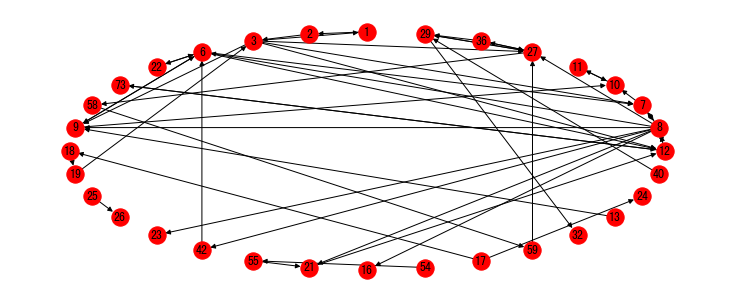

In [27]:
# 图可视化(只选取weight最大的前50个)
top_n = 50
sorted_weight_edges = sorted(list(DG.edges.data()), key=lambda x: x[2]['weight'], reverse=True)[:top_n]
sorted_weight_edges = [(node_1, node_2, weight['weight']) for node_1, node_2, weight in sorted_weight_edges]

# 生成子图
sub_DG = nx.DiGraph()
sub_DG.add_weighted_edges_from(sorted_weight_edges)

# 画图
plt.figure(figsize=(10, 4))
nx.draw_shell(sub_DG, with_labels=True)
plt.show()

## 样本特征构建

In [28]:
# 定义构建函数
def creat_gcn_features(x, total_num):
    matrix = np.zeros(shape=(len(x), total_num, len(x.columns)))
    for sub_matrix, sample in zip(matrix, x.values):
        for time_seq, api_idx in enumerate(sample):
            sub_matrix[api_idx, time_seq] = 1
    return matrix

In [29]:
# 生成特征、查看维度
x_train_gcn = creat_gcn_features(x_train, api_num)
x_test_gcn = creat_gcn_features(x_test, api_num)
print('--- shape: (样本数, api总数, 时间步) ---')
print('x_train_gcn', x_train_gcn.shape)
print('x_test_gcn', x_test_gcn.shape)

--- shape: (样本数, api总数, 时间步) ---
x_train_gcn (29394, 264, 100)
x_test_gcn (14478, 264, 100)


## 图算子构建

**Combinatorial Laplacian**: $L=D-A$

**Symmetric normalized Laplacian**: $L^{sys}=D^{-\frac{1}{2}} L D^{-\frac{1}{2}}$

In [30]:
from functools import reduce

In [31]:
# 生成邻接矩阵
A_matrix = nx.adjacency_matrix(G, weight=None).toarray()

# 生成度矩阵
D_matrix = np.identity(api_num) * A_matrix.sum(axis=1)

# 采用 Symmetric normalized Laplacian 生成拉普拉斯矩阵
L_matrix = D_matrix - A_matrix
D_matrix_sqrt = np.identity(api_num) * (1/np.sqrt(A_matrix.sum(axis=1)))
L_sys = reduce(np.dot, [D_matrix_sqrt, L_matrix, D_matrix_sqrt])

## 定义 GCN 模型

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

In [33]:
# 定义 GCN 模型
class GCN(nn.Module):
    def __init__(self, L_sys):
        super(GCN, self).__init__()
        self.L_sys = L_sys
        self.mlp = nn.Linear(528, 2)
        self.linear = nn.Sequential(
            nn.Linear(100, 2),
            nn.ReLU(),
        )
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self,x):
        x = self.L_sys.mm(x)
        x = self.linear(x)
        x = x.view(1,-1)
        x = self.mlp(x)
        return x
    
    def predict_proba(self, x):
        x = self.forward(x)
        proba = self.softmax(x)
        return proba

## GCN 模型训练

In [35]:
# GPU训练
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

# 创建模型
L_sys = torch.Tensor(L_sys).to(device) # 算法因子转换成tensor
gcn = GCN(L_sys=L_sys)
gcn.to(device)

# 数据格式转换为tensor
x_train_gcn_tensor = torch.Tensor(x_train_gcn)
x_test_gcn_tensor = torch.Tensor(x_test_gcn)
y_train_tensor  = torch.Tensor(y_train.values).long()

# 定义超参数
EPOCH = 100
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.Adam(gcn.parameters())
loss_list = []

# 模型训练
for epoch in range(EPOCH):
    for idx, (x, y) in enumerate(zip(x_train_gcn_tensor, y_train_tensor)):
        x, y = x.to(device), y.to(device)
        output = gcn(x)
        y = y.view(1)
        loss = loss_fun(output, y)
        optimizer.zero_grad()
        loss.backward()
        loss_list.append(loss.item())
        optimizer.step()
        if (idx+1) % 3000 == 0:
            e = time.time()
            print('Epoch:{}, idx:{}'.format(epoch, idx+1))

Epoch:0, idx:3000
Epoch:0, idx:6000
Epoch:0, idx:9000
Epoch:0, idx:12000
Epoch:0, idx:15000
Epoch:0, idx:18000
Epoch:0, idx:21000
Epoch:0, idx:24000
Epoch:0, idx:27000
Epoch:1, idx:3000
Epoch:1, idx:6000
Epoch:1, idx:9000
Epoch:1, idx:12000
Epoch:1, idx:15000
Epoch:1, idx:18000
Epoch:1, idx:21000
Epoch:1, idx:24000
Epoch:1, idx:27000
Epoch:2, idx:3000
Epoch:2, idx:6000
Epoch:2, idx:9000
Epoch:2, idx:12000
Epoch:2, idx:15000
Epoch:2, idx:18000
Epoch:2, idx:21000
Epoch:2, idx:24000
Epoch:2, idx:27000
Epoch:3, idx:3000
Epoch:3, idx:6000
Epoch:3, idx:9000
Epoch:3, idx:12000
Epoch:3, idx:15000
Epoch:3, idx:18000
Epoch:3, idx:21000
Epoch:3, idx:24000
Epoch:3, idx:27000
Epoch:4, idx:3000
Epoch:4, idx:6000
Epoch:4, idx:9000
Epoch:4, idx:12000
Epoch:4, idx:15000
Epoch:4, idx:18000
Epoch:4, idx:21000
Epoch:4, idx:24000
Epoch:4, idx:27000
Epoch:5, idx:3000
Epoch:5, idx:6000
Epoch:5, idx:9000
Epoch:5, idx:12000
Epoch:5, idx:15000
Epoch:5, idx:18000
Epoch:5, idx:21000
Epoch:5, idx:24000
Epoch:5, id

Epoch:46, idx:27000
Epoch:47, idx:3000
Epoch:47, idx:6000
Epoch:47, idx:9000
Epoch:47, idx:12000
Epoch:47, idx:15000
Epoch:47, idx:18000
Epoch:47, idx:21000
Epoch:47, idx:24000
Epoch:47, idx:27000
Epoch:48, idx:3000
Epoch:48, idx:6000
Epoch:48, idx:9000
Epoch:48, idx:12000
Epoch:48, idx:15000
Epoch:48, idx:18000
Epoch:48, idx:21000
Epoch:48, idx:24000
Epoch:48, idx:27000
Epoch:49, idx:3000
Epoch:49, idx:6000
Epoch:49, idx:9000
Epoch:49, idx:12000
Epoch:49, idx:15000
Epoch:49, idx:18000
Epoch:49, idx:21000
Epoch:49, idx:24000
Epoch:49, idx:27000
Epoch:50, idx:3000
Epoch:50, idx:6000
Epoch:50, idx:9000
Epoch:50, idx:12000
Epoch:50, idx:15000
Epoch:50, idx:18000
Epoch:50, idx:21000
Epoch:50, idx:24000
Epoch:50, idx:27000
Epoch:51, idx:3000
Epoch:51, idx:6000
Epoch:51, idx:9000
Epoch:51, idx:12000
Epoch:51, idx:15000
Epoch:51, idx:18000
Epoch:51, idx:21000
Epoch:51, idx:24000
Epoch:51, idx:27000
Epoch:52, idx:3000
Epoch:52, idx:6000
Epoch:52, idx:9000
Epoch:52, idx:12000
Epoch:52, idx:1500

Epoch:93, idx:9000
Epoch:93, idx:12000
Epoch:93, idx:15000
Epoch:93, idx:18000
Epoch:93, idx:21000
Epoch:93, idx:24000
Epoch:93, idx:27000
Epoch:94, idx:3000
Epoch:94, idx:6000
Epoch:94, idx:9000
Epoch:94, idx:12000
Epoch:94, idx:15000
Epoch:94, idx:18000
Epoch:94, idx:21000
Epoch:94, idx:24000
Epoch:94, idx:27000
Epoch:95, idx:3000
Epoch:95, idx:6000
Epoch:95, idx:9000
Epoch:95, idx:12000
Epoch:95, idx:15000
Epoch:95, idx:18000
Epoch:95, idx:21000
Epoch:95, idx:24000
Epoch:95, idx:27000
Epoch:96, idx:3000
Epoch:96, idx:6000
Epoch:96, idx:9000
Epoch:96, idx:12000
Epoch:96, idx:15000
Epoch:96, idx:18000
Epoch:96, idx:21000
Epoch:96, idx:24000
Epoch:96, idx:27000
Epoch:97, idx:3000
Epoch:97, idx:6000
Epoch:97, idx:9000
Epoch:97, idx:12000
Epoch:97, idx:15000
Epoch:97, idx:18000
Epoch:97, idx:21000
Epoch:97, idx:24000
Epoch:97, idx:27000
Epoch:98, idx:3000
Epoch:98, idx:6000
Epoch:98, idx:9000
Epoch:98, idx:12000
Epoch:98, idx:15000
Epoch:98, idx:18000
Epoch:98, idx:21000
Epoch:98, idx:24

## 模型评估

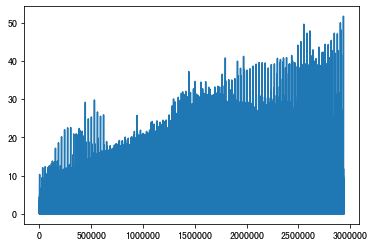

In [36]:
# loss 曲线
plt.plot(loss_list)
plt.show()

In [38]:
# 模型预测
result_gcn = []
result_gcn_proba = []
for x in x_test_gcn_tensor:
    x.to(device)
    gcn_predict_proba = gcn.predict_proba(x)
    result_gcn_proba.append(gcn_predict_proba[0,1].item())
    result_gcn.append(gcn_predict_proba.argmax().item())
    
    
# auc值计算
gcn_y_score = np.array(result_gcn_proba)
gcn_fpr, gcn_tpr, thresholds = roc_curve(y_test, gcn_y_score)
gcn_roc_auc = auc(gcn_fpr, gcn_tpr)

# 评估分数
print('--- GCN Model ---')
print('准确率：{:.4f}'.format(accuracy_score(result_gcn, y_test)))
print('精确度：{:.4f}'.format(precision_score(result_gcn, y_test)))
print('召回率：{:.4f}'.format(recall_score(result_gcn, y_test)))
print('AUC值：{:.4f}'.format(gcn_roc_auc))

--- GCN Model ---
准确率：0.9850
精确度：0.9930
召回率：0.9917
AUC值：0.8727
